In [ ]:
from dotenv import load_dotenv

load_dotenv()

# Nodes and edges

In [ ]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

from IPython.display import Image

In [ ]:
def add_one(input: list[HumanMessage]):
    input[0].content = input[0].content + "a"
    return input

In [ ]:
graph = MessageGraph()

graph.add_node("branch_a", add_one)
graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_one)
graph.add_node("final_node", add_one)

graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")
graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")
graph.add_edge("final_node", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

Image(runnable.get_graph().draw_mermaid_png())

In [ ]:
runnable.invoke("a")

## Conditional Edges

In [ ]:
def entry(input: list[HumanMessage]):
    return input


def work_with_b(input: list[HumanMessage]):
    print("use_b")
    return input


def work_with_c(input: list[HumanMessage]):
    print("use_c")
    return input


def router(input: list[HumanMessage]):
    if "use_b" in input[0].content:
        return "use_b"
    else:
        return "use_c"
    

graph = MessageGraph()

graph.add_node("entry", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

graph.add_conditional_edges(
    "entry",
    router,
    {
        "use_b": "branch_b",
        "use_c": "branch_c"
    },
)
graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

graph.set_entry_point("entry")

runnable = graph.compile()

Image(runnable.get_graph().draw_mermaid_png())



In [ ]:
runnable.invoke("Hello")

In [ ]:
runnable.invoke("use_b")

## Cycles

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

llm = ChatOpenAI()

In [ ]:
def entry(input: list[HumanMessage]):
    return input


def action(input: list[HumanMessage]):
    print("Action Taken: ", [msg.content for msg in input])

    if len(input) > 5:
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))

    return input


def should_continue(input: list):
    last_message = input[-1]
    if "end" in last_message.content:
        return "__end__"
    else:
        return "action"
    

graph = MessageGraph()

graph.add_node("agent", entry)
graph.add_node("action", action)

graph.add_conditional_edges(
    "agent",
    should_continue,
    {
        "action": "action",
        "__end__": END
    },
)
graph.add_edge("action", "agent")
graph.set_entry_point("agent")

runnable = graph.compile()

Image(runnable.get_graph().draw_mermaid_png())


In [ ]:
runnable.invoke("Hello world")

## Real Agent

In [ ]:
import operator
import random
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, MessageGraph

llm = ChatOpenAI()

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    api_call_count: int = 0

In [ ]:
@tool
def fake_weather_api(city: str) -> str:
    """Returns the weather for a given city."""
    if random.randint(0, 3) == 0:
        return f"Sunny, {random.randint(10, 30)} degrees"
    else:
        return "Service unavailable"

In [ ]:
llm_with_tools = llm.bind_tools([fake_weather_api])

tool_mapping = {
    "fake_weather_api": fake_weather_api,
}

messages = [HumanMessage("How will the weather be in Copenhagen today? I would like to eat outside if possible")]
llm_output = llm_with_tools.invoke(messages)
messages.append(llm_output)


for tool_call in llm_output.tool_calls:
    tool_name = tool_call["name"].lower()
    tool = tool_mapping[tool_name]
    tool_output = tool.invoke(tool_call["args"])
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

llm_with_tools.invoke(messages)

In [ ]:
def should_continue(state: AgentState):
    print("--> should_continue")
    messages = state["messages"]
    last_message = messages[-1]

    print(f"State: {state}")
    print(f"Last message: {last_message}")
    print(f"Tool calls: {last_message.tool_calls}")

    if not last_message.tool_calls:
        print("---> Going to end")
        return "end"
    else:
        print("---> Going to continue")
        return "continue"
    

def call_model(state: AgentState):
    print("--> call_model")
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)

    print("Response: ", response)


    return {
        "messages": [response],
        "api_call_count": state["api_call_count"],
    }


def call_tool(state: AgentState):
    print("--> call_tool")
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool_name = tool_call["name"].lower()
    tool = tool_mapping[tool_name]
    tool_output = tool.invoke(tool_call["args"])

    state["api_call_count"] += 1
    print("Tool output: ", tool_output)
    print("API call count after this tool call: ", state["api_call_count"])
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {
        "messages": [tool_message],
        "api_call_count": state["api_call_count"],
    }


from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)


workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END
    },
)
workflow.add_edge("action", "agent")
workflow.set_entry_point("agent")

app = workflow.compile()
Image(app.get_graph().draw_mermaid_png())



In [ ]:
from langchain_core.messages import SystemMessage

system_message = SystemMessage(content="You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again")
human_message = HumanMessage(content="How will the weather be in Copenhagen today?")
messages = [system_message, human_message]

r = app.invoke({"messages": messages, "api_call_count": 0})




# LangGraph vs LCEL

In [1]:
from langchain.schema import Document
from langchain_community.vectorstores import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI, OpenAIEmbeddings



### With LCEL

In [ ]:

embedding_function = OpenAIEmbeddings()

In [2]:
docs = [
    Document(page_content="Raistlin is a mage", metadata={"source": "Dragonlance"}),
    Document(page_content="Tanis is a ranger", metadata={"source": "Dragonlance"}),
]


db = Chroma.from_documents(docs, embedding_function)
retriever = db.as_retriever(search_kwargs={"k": 2})

In [3]:
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

In [5]:
template = """Answer the question based only on the following context:
{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
llm = ChatOpenAI()

retrieval_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [6]:
retrieval_chain.invoke("What type is Tanis?")

'Tanis is a ranger.'

### With LangGraph

In [11]:
from typing import TypedDict
from langchain_core.messages import BaseMessage


chain_with_prompt = prompt | llm | StrOutputParser()

In [10]:
class AgentState(TypedDict):
    question: str
    raw_docs: list[BaseMessage]
    formatted_docs: list[str]
    generation: str



In [12]:
def get_docs(state: AgentState):
    print("Getting documents...", state)
    question = state["question"]
    docs = retriever.invoke(question)
    state["raw_docs"] = docs
    return state


def format_docs(state: AgentState):
    print("Formatting documents...", state)
    documents = state["raw_docs"]
    state["formatted_docs"] = "\n\n".join([doc.page_content for doc in documents])
    return state


def generate(state: AgentState):
    print("Generating response...", state)
    question = state["question"]
    formatted_docs = state["formatted_docs"]
    result = chain_with_prompt.invoke({"question": question, "context": formatted_docs})
    state["generation"] = result
    return state
    

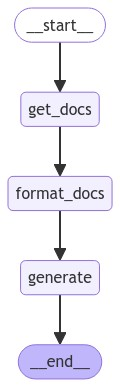

In [17]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

workflow = StateGraph(AgentState)

workflow.add_node("get_docs", get_docs)
workflow.add_node("format_docs", format_docs)
workflow.add_node("generate", generate)

workflow.add_edge("get_docs", "format_docs")
workflow.add_edge("format_docs", "generate")
workflow.add_edge("generate", END)

workflow.set_entry_point("get_docs")

app = workflow.compile()

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [15]:
app.invoke({"question": "What type is Tanis?"})

Getting documents... {'question': 'What type is Tanis?', 'raw_docs': None, 'formatted_docs': None, 'generation': None}
Formatting documents... {'question': 'What type is Tanis?', 'raw_docs': [Document(metadata={'source': 'Dragonlance'}, page_content='Tanis is a ranger'), Document(metadata={'source': 'Dragonlance'}, page_content='Raistlin is a mage')], 'formatted_docs': None, 'generation': None}
Generating response... {'question': 'What type is Tanis?', 'raw_docs': [Document(metadata={'source': 'Dragonlance'}, page_content='Tanis is a ranger'), Document(metadata={'source': 'Dragonlance'}, page_content='Raistlin is a mage')], 'formatted_docs': 'Tanis is a ranger\n\nRaistlin is a mage', 'generation': None}


{'question': 'What type is Tanis?',
 'raw_docs': [Document(metadata={'source': 'Dragonlance'}, page_content='Tanis is a ranger'),
  Document(metadata={'source': 'Dragonlance'}, page_content='Raistlin is a mage')],
 'formatted_docs': 'Tanis is a ranger\n\nRaistlin is a mage',
 'generation': 'Tanis is a ranger.'}

# Hierarchical Agents - Boss and subordinate agents
[langgraph/crash_coding_courses_langgraph.ipynb (2-2)](https://www.youtube.com/watch?v=9HhcFiSgLok&list=PLNVqeXDm5tIqUIPQHLk5Xw5mpisruvsac&index=6)


In [18]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

In [19]:
class TransferNewsGrader(BaseModel):
    """Binary score for relevance check on football transfer news"""
    binary_score: str = Field(description="The article is about football transfers, 'yes' og 'no'")


llm = ChatOpenAI()
structured_llm_grader = llm.with_structured_output(TransferNewsGrader)

system = """You are a grader assessing whether a news article conserns a football transfer. \n
Check if the article explicitly mentions player transfers between clubs, potential transfers or confirmed transfers. \n
If the article is about football transfers, answer 'yes', otherwise answer 'no'."""

grade_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "News Article:\n\n {article}"),
])

evaluator = grade_prompt | structured_llm_grader


In [26]:
r = evaluator.invoke({"article": "Raistlin is a powerfull mage"})
print(r)
print(r.binary_score)

binary_score='no'
no


In [70]:
class ArticlePostabilityGrader(BaseModel):
    """Binary check if article is postable given word_count, sensationalism and language"""
    can_be_posted: str = Field(description="The article can be posted (meets_word_count, is_sensational, is_in_danish_language are all 'yes'), 'yes' or 'no'")
    meets_word_count: str = Field(description="The article has more than 200 words, 'yes' or 'no'")
    is_sensational: str = Field(description="The article is written in a sensational style, 'yes' or 'no'")
    is_in_danish_language: str = Field(description="The article is written in Danish, 'yes' or 'no'")

llm_postability = ChatOpenAI()
structured_llm_postability_grader = llm_postability.with_structured_output(ArticlePostabilityGrader)

postability_system = """You are a grader assessing whether a news article is ready to be posted, if it meets the minimum word count of 200 words, is written in a sensationalistic style, and if it is in Danish. \n
    Evaluate the article for grammatical errors, completeness, appropriateness for publication, and EXAGERATED sensationalism. \n
    Also, confirm if the language used in the article is Danish and it meets the word count requirement. \n
    Provide four binary scores: one to indicate if the article can be posted ('yes' or 'no'), one for adequate word count ('yes' or 'no'), one for sensationalistic writing ('yes' or 'no'), and another if the language is Danish ('yes' or 'no').
"""
postability_grade_prompt = ChatPromptTemplate.from_messages([
    ("system", postability_system),
    ("human", "News Article:\n\n {article}"),
])
news_chef = postability_grade_prompt | structured_llm_postability_grader

# result = news_chef.invoke({"article": "Alex Keaton is transfering to the mexican club Chivas to be closer to his pornstar girlfriend"})
# print(result)

In [71]:
llm_translation = ChatOpenAI()

translation_system = """You are a translator translating an article into Danish. \n
Translate the article accurately while mainting the original meaning."""
translation_prompt = ChatPromptTemplate.from_messages([
    ("system", translation_system),
    ("human", "English text:\n\n {article}"),
])

translator = translation_prompt | llm_translation
# result = translator.invoke({"article": "Alex Keaton is transfering to the mexican club Chivas to be closer to his pornstar girlfriend"})

In [72]:
llm_expansion = ChatOpenAI()
expansion_system = """You are a writer tasked with expanding the given article to at least 200 words while maintaining the original meaning of the article"""
expansion_prompt = ChatPromptTemplate.from_messages([
    ("system", expansion_system),
    ("human", "News Article:\n\n {article}"),
])

expander = expansion_prompt | llm_expansion
# result = expander.invoke({"article": "Alex Keaton is transfering to the mexican club Chivas to be closer to his pornstar girlfriend"})
# print(result)

In [73]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Literal


class AgentState(TypedDict):
    article_state: str

In [74]:
def get_transfer_news_grade(state: AgentState):
    print(f"get_transfer_news_grade: {state}")
    print("Evaluator: Reading article but doing nothing to change it...")
    return state


def evaluate_article(state: AgentState):
    print(f"Evaluate_article: {state}")
    print("News: Reading article but doing nothing to change it")
    return state


def translate_article(state: AgentState):
    print(f"Translate_article: {state}")
    article = state["article_state"]
    result = translator.invoke({"article": article})
    state["article_state"] = result.content
    return state


def expand_article(state: AgentState):
    print(f"Expand_article: {state}")
    article = state["article_state"]
    result = expander.invoke({"article": article})
    state["article_state"] = result.content
    return state


def publisher(state: AgentState):
    print(f"Publisher: {state}")
    print("PUBLISHING...")
    return state


def evaluator_router(state: AgentState) -> Literal["news_chef", "not_relevant"]:
    article = state["article_state"]
    evaluator = grade_prompt | structured_llm_grader
    result = evaluator.invoke({"article": article})

    print(f"evaluator_router state: {state}")
    print("Evaluator result: ", result)

    if result.binary_score == "yes":
        return "news_chef"
    else:
        return "not_relevant"


def news_chef_router(state: AgentState) -> Literal["translator", "publisher", "expander"]:
    article = state["article_state"]
    result = news_chef.invoke({"article": article})
    print(f"news_chef_router state: {state}")
    print("News chef result: ", result)

    if result.can_be_posted == "yes":
        return "publisher"
    elif result.is_in_danish_language == "no":
        if result.meets_word_count == "no" or result.is_sensational == "no":
            return "expander"
    
    return "translator"


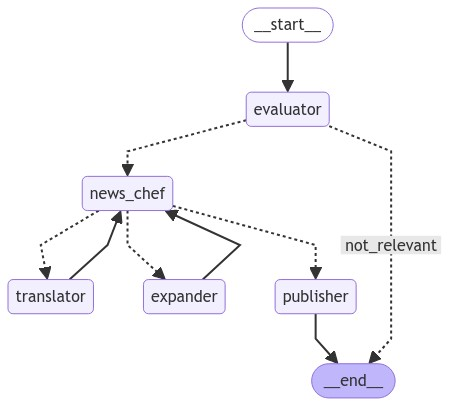

In [75]:
workflow = StateGraph(AgentState)

workflow.add_node("evaluator", get_transfer_news_grade)
workflow.add_node("news_chef", evaluate_article)
workflow.add_node("translator", translate_article)
workflow.add_node("expander", expand_article)
workflow.add_node("publisher", publisher)

workflow.set_entry_point("evaluator")

workflow.add_conditional_edges(
    "evaluator",
    evaluator_router,
    {"news_chef": "news_chef", "not_relevant": END}
)

workflow.add_conditional_edges(
    "news_chef",
    news_chef_router,
    {"translator": "translator", "publisher": "publisher", "expander": "expander"}
)
workflow.add_edge("translator", "news_chef")
workflow.add_edge("expander", "news_chef")
workflow.add_edge("publisher", END)


app = workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [76]:
app.invoke({"article_state": "Alex Keaton is transfering to the mexican club Chivas to be closer to his pornstar girlfriend"})

get_transfer_news_grade: {'article_state': 'Alex Keaton is transfering to the mexican club Chivas to be closer to his pornstar girlfriend'}
Evaluator: Reading article but doing nothing to change it...
evaluator_router state: {'article_state': 'Alex Keaton is transfering to the mexican club Chivas to be closer to his pornstar girlfriend'}
Evaluator result:  binary_score='yes'
Evaluate_article: {'article_state': 'Alex Keaton is transfering to the mexican club Chivas to be closer to his pornstar girlfriend'}
News: Reading article but doing nothing to change it
news_chef_router state: {'article_state': 'Alex Keaton is transfering to the mexican club Chivas to be closer to his pornstar girlfriend'}
News chef result:  can_be_posted='no' meets_word_count='no' is_sensational='yes' is_in_danish_language='no'
Expand_article: {'article_state': 'Alex Keaton is transfering to the mexican club Chivas to be closer to his pornstar girlfriend'}
Evaluate_article: {'article_state': "In a surprising turn 

{'article_state': 'I en overraskende vending af begivenheder er det blevet bekræftet, at den talentfulde fodboldspiller, Alex Keaton, er sat til at skifte til den mexicanske klub Chivas. Årsagen bag denne uventede transfer siges at være for at være tættere på sin kæreste, som er en kendt pornostjerne.\n\nKeaton, kendt for sine færdigheder på banen, har været i centrum for opmærksomheden i fodboldverdenen med sine bemærkelsesværdige præstationer. Hans beslutning om at slutte sig til Chivas har fået øjenbrynene til at hæve sig blandt fans og eksperter, med mange spekulationer om, hvilken indvirkning dette skifte vil have på hans karriere.\n\nMens Keatons personlige liv ofte har været genstand for medieopmærksomhed, har denne seneste udvikling tilføjet en ny dimension til hans offentlige person. Beslutningen om at prioritere sit forhold ved at flytte til et nyt land for sin kæreste har startet debat blandt tilhængere og kritikere.\n\nMens Keaton forbereder sig på at påbegynde dette nye ka